# Required Libraries and Modules

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import IFrame



## Loading and Inspecting Data

In [2]:
# Load the dataset
data = pd.read_csv('UK_Accident.csv', index_col=0)

# Print information about the dataset
data.info()


C:\Users\Nimish\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1504150 entries, 0 to 464696
Data columns (total 32 columns):
 #   Column                                       Non-Null Count    Dtype  
---  ------                                       --------------    -----  
 0   Accident_Index                               1504150 non-null  object 
 1   Location_Easting_OSGR                        1504049 non-null  float64
 2   Location_Northing_OSGR                       1504150 non-null  float64
 3   Longitude                                    1504049 non-null  float64
 4   Latitude                                     1504150 non-null  float64
 5   Police_Force                                 1504150 non-null  int64  
 6   Accident_Severity                            1504150 non-null  int64  
 7   Number_of_Vehicles                           1504150 non-null  int64  
 8   Number_of_Casualties                         1504150 non-null  int64  
 9   Date                                         15

# Data Visualization Functions
Here are several functions for visualizing data:

In [2]:

# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if 1 < nunique[col] < 50]]  # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow  # Modified from '/' to '//'
    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if not np.issubdtype(type(columnDf.iloc[0]), np.number):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()


# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = "DataFrame"  # Replace with actual DataFrame name
    df = df.dropna('columns')  # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include=[np.number])  # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10:  # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k=1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


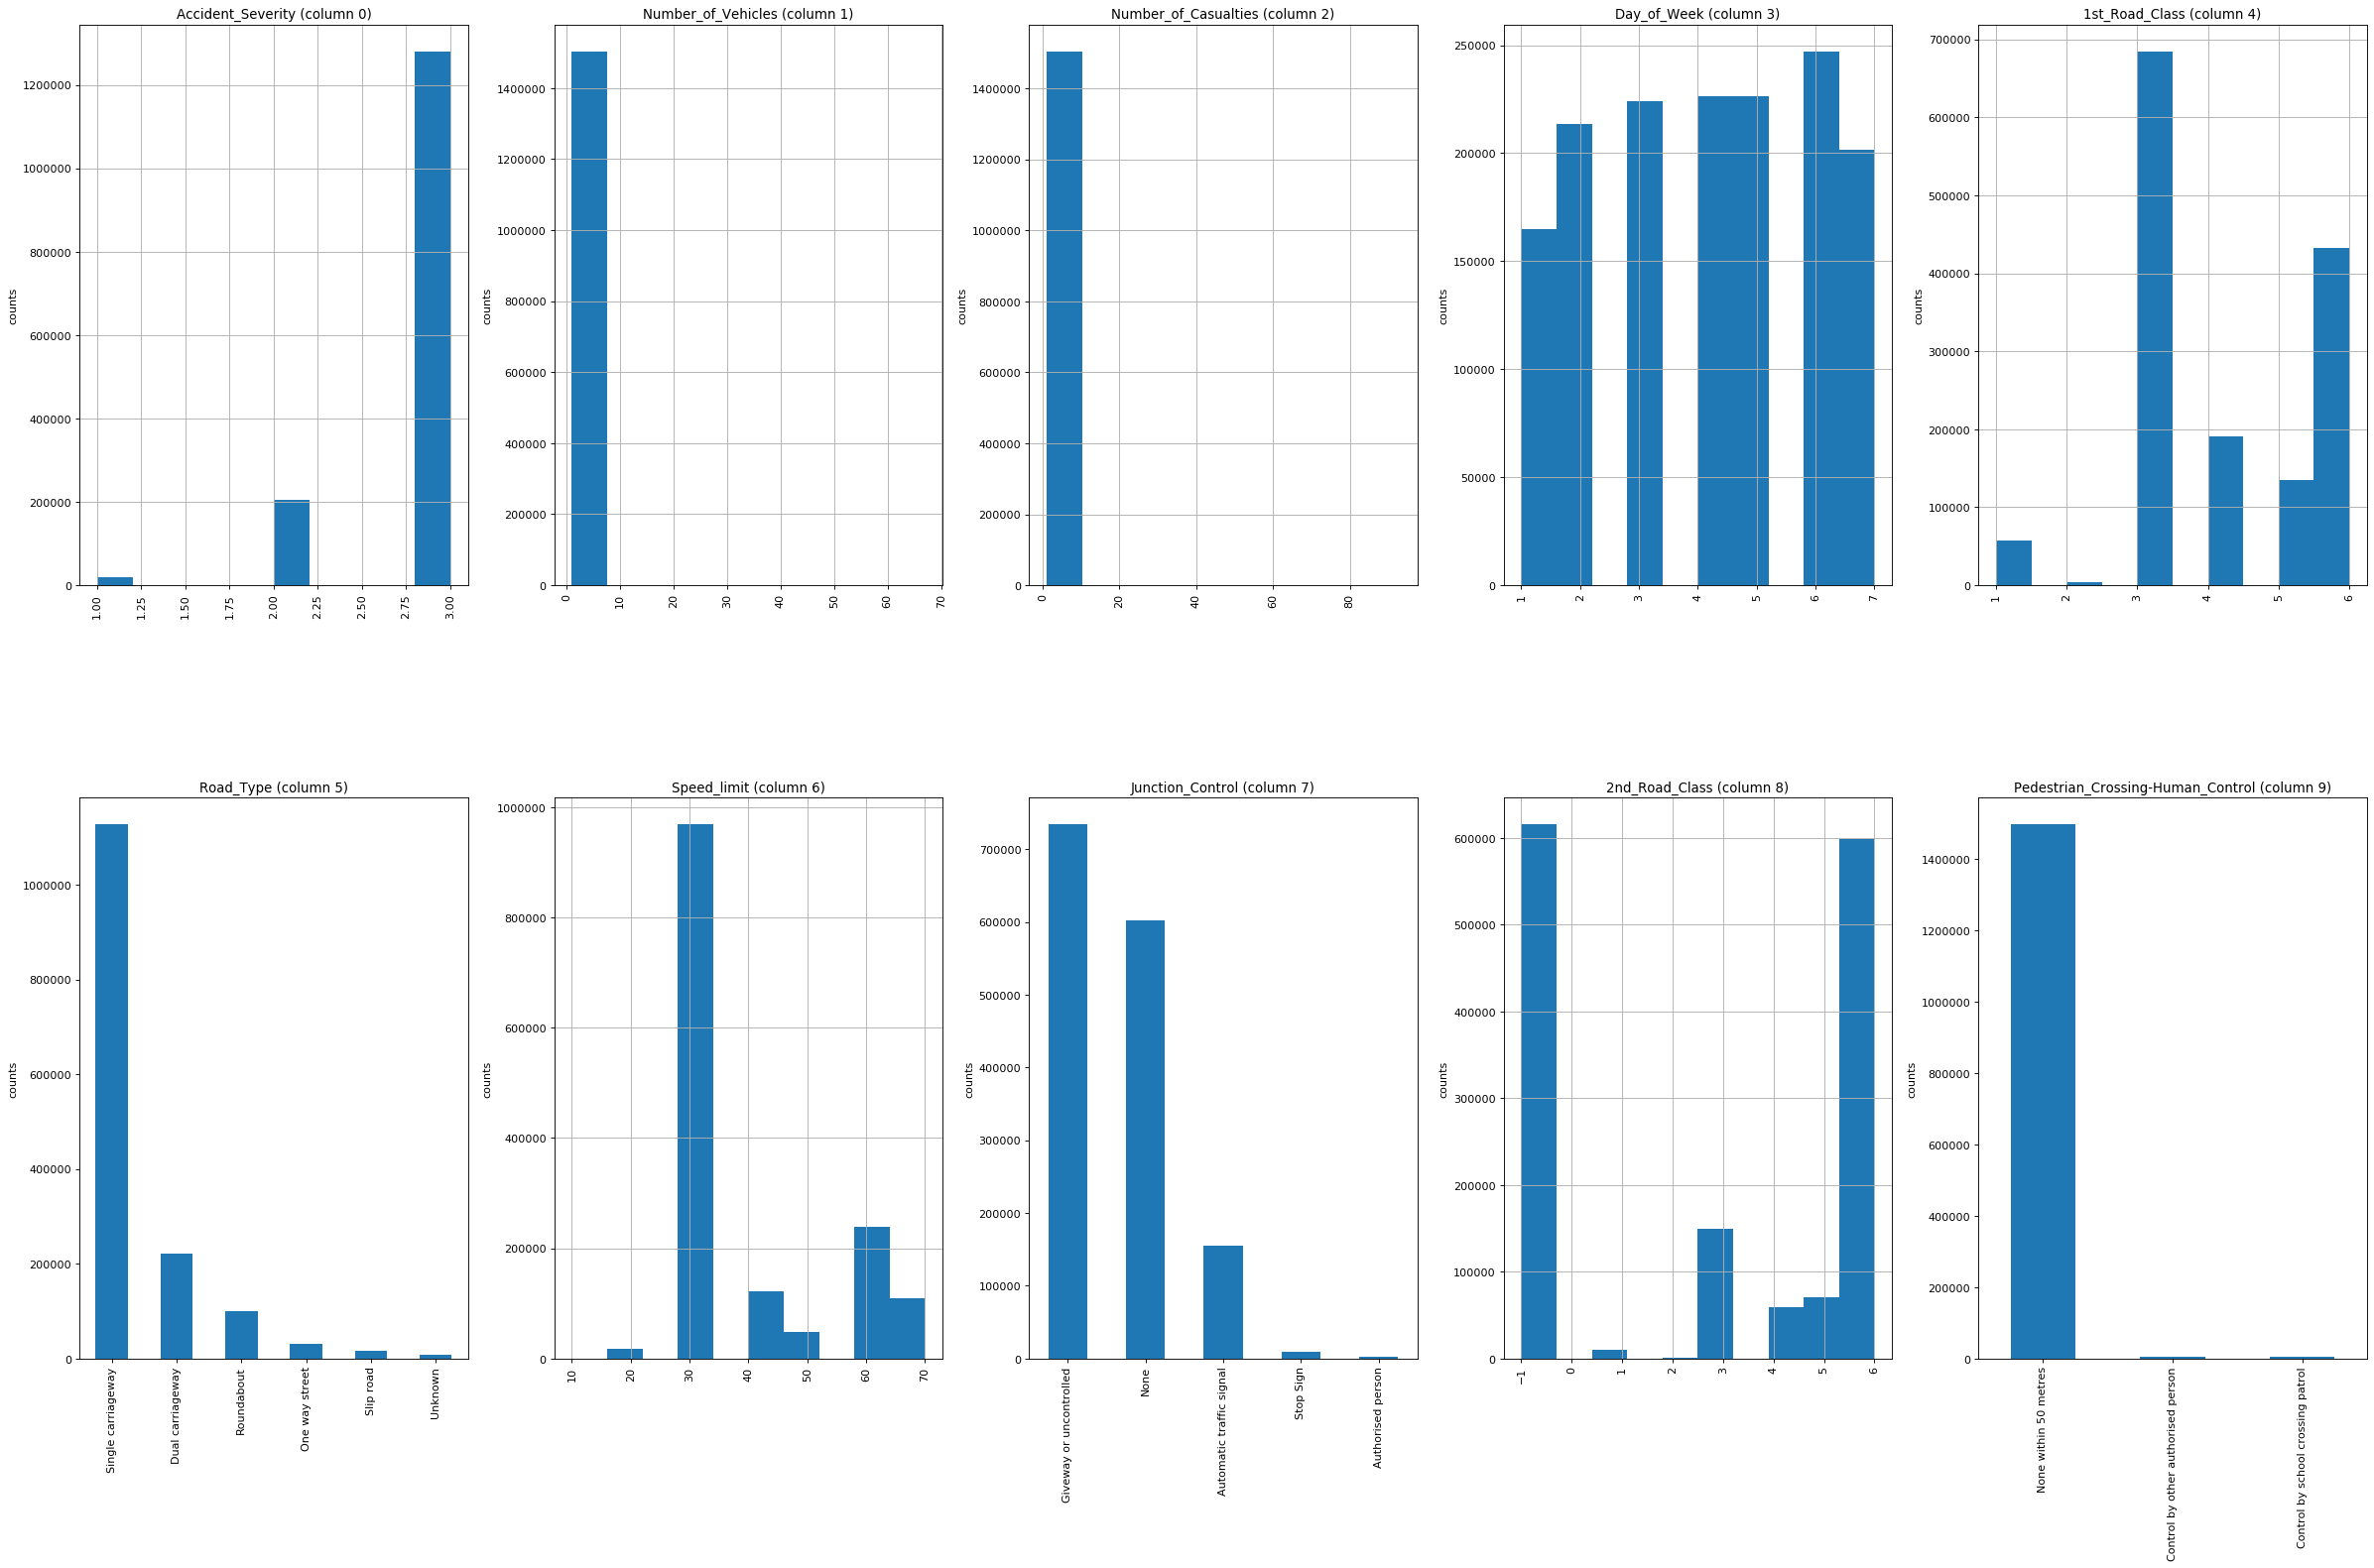

In [65]:
plotPerColumnDistribution(data, 10, 5)

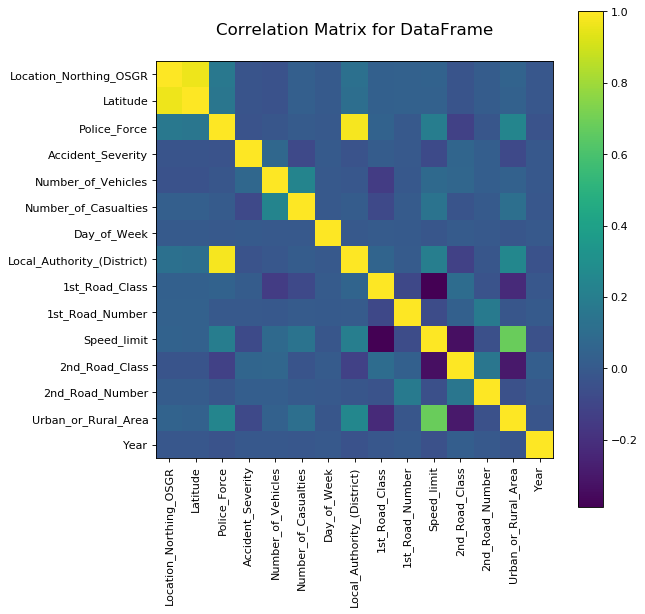

In [75]:
plotCorrelationMatrix(data, 8)

# Speed Zone Accidents Percentage
To visualize the percentage of accidents in different speed zones, you can use the following code:

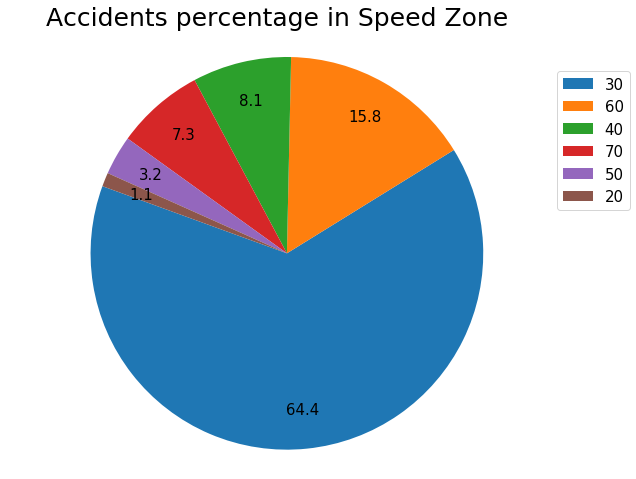

In [3]:
speed_zone_accidents = data.loc[data['Speed_limit'].isin([20, 30, 40, 50, 60, 70])]
speed = speed_zone_accidents['Speed_limit'].value_counts()

explode = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0) 
plt.figure(figsize=(10, 8))
plt.pie(speed.values, labels=None, autopct='%.1f', pctdistance=0.8, labeldistance=1.9, explode=explode, shadow=False, startangle=160, textprops={'fontsize': 15})
plt.axis('equal')
plt.legend(speed.index, bbox_to_anchor=(1, 0.7), loc="center right", fontsize=15, bbox_transform=plt.gcf().transFigure)
plt.figtext(.5, .9, 'Accidents percentage in Speed Zone', fontsize=25, ha='center')
plt.show()


# Predicting Accident Severity
To predict accident severity using relevant features, you can use the following code:

In [23]:


# Select relevant features for prediction
features = ['Number_of_Vehicles', 'Number_of_Casualties', 'Road_Surface_Conditions', 'Weather_Conditions']

# Preprocess the data
le = LabelEncoder()
data['Road_Surface_Conditions'] = le.fit_transform(data['Road_Surface_Conditions'])
data['Weather_Conditions'] = le.fit_transform(data['Weather_Conditions'])

# Split the data into training and testing sets
X = data[features]
y = data['Accident_Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8510786823122694


# Accident Hotspot Detection and Visualization
To detect and visualize accident hotspots based on latitude and longitude, you can use the following code:

In [5]:


# Select relevant features for hotspot detection
features = ['Latitude', 'Longitude']

# Filter the data for hotspot detection
hotspot_data = data[features].dropna()

# Create a folium map
map_hotspots = folium.Map(location=[hotspot_data['Latitude'].mean(), hotspot_data['Longitude'].mean()], zoom_start=10)

# Generate heatmap
heat_data = [[row['Latitude'], row['Longitude']] for index, row in hotspot_data.iterrows()]
HeatMap(heat_data).add_to(map_hotspots)

# Save the map as an HTML file
map_hotspots.save("accident_hotspots.html")


In [6]:
# Display the map in the notebook using an IFrame
IFrame(src='accident_hotspots.html', width=700, height=500)


# Road Type Classification

To classify road types based on relevant features, you can use the following code:


In [28]:


# Select relevant features for classification
features = ['1st_Road_Class', '1st_Road_Number', 'Junction_Control']

# Preprocess the data
le = LabelEncoder()
data['1st_Road_Class'] = le.fit_transform(data['1st_Road_Class'])
data['Junction_Control'] = le.fit_transform(data['Junction_Control'])

# Split the data into training and testing sets
X = data[features]
y = data['Road_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8092710168533723


# Time-Series Analysis: Accidents Over Time

To perform time-series analysis on the number of accidents over time, you can use the following code:



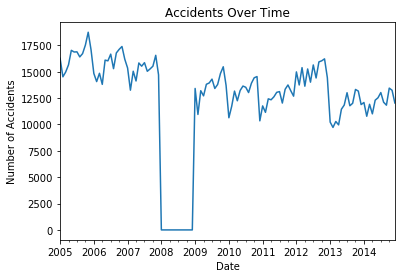

Wall time: 3.84 s


In [48]:


# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Perform time-series analysis
# Example: Plot the number of accidents per month
monthly_accidents = data.resample('M').size()
monthly_accidents.plot()
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.title('Accidents Over Time')
plt.show()


# Analysis and Classification of Accident Severity

To perform analysis and classification of accident severity based on relevant features, you can use the following code:


In [30]:
# Select relevant features for analysis
features = ['Weather_Conditions', 'Road_Surface_Conditions']

# Preprocess the data
le = LabelEncoder()
data['Weather_Conditions'] = le.fit_transform(data['Weather_Conditions'])
data['Road_Surface_Conditions'] = le.fit_transform(data['Road_Surface_Conditions'])

# Split the data into training and testing sets
X = data[features]
y = data['Accident_Severity']  # or any other relevant target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8511883788186019


# Prediction of Police Attendance at Accident Scenes
To predict whether a police officer attended the scene of an accident based on relevant features, you can use the following code:

In [38]:

# Select relevant features for prediction
features = ['Accident_Severity', 'Day_of_Week', 'Road_Type', 'Weather_Conditions']

# Preprocess the data
# Apply appropriate encoding, feature engineering, and data transformations

# Drop rows with missing values in the target variable
data = data.dropna(subset=['Did_Police_Officer_Attend_Scene_of_Accident'])

# Encode categorical features
le = LabelEncoder()
data['Road_Type'] = le.fit_transform(data['Road_Type'])
data['Weather_Conditions'] = le.fit_transform(data['Weather_Conditions'])

# Extract hour component from 'Time' column
data['Time'] = pd.to_datetime(data['Time']).dt.hour

# Split the data into training and testing sets
X = data[features]
y = data['Did_Police_Officer_Attend_Scene_of_Accident']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8137984908420038


# Convert 'Year' Column to Datetime Format and Plot Accident Trends over Time

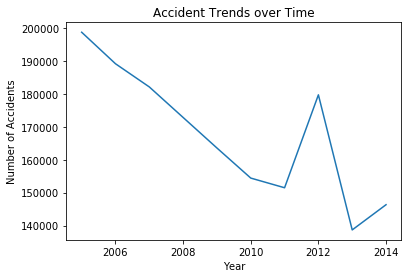

In [54]:
# Convert the 'Year' column to datetime format
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

# Group the data by year and count the number of accidents
accidents_per_year = df.groupby(df['Year'].dt.year)['Accident_Index'].count()

# Plot the time series of accidents per year
plt.plot(accidents_per_year.index, accidents_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.title('Accident Trends over Time')
plt.show()
